In [1]:
from datasets import load_dataset
from datasets import DatasetDict
import re
import matplotlib.pyplot as plt

/NL/strategic-compute/work/svenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# GSM8K

In [2]:
ANS_RE = re.compile(r"#### (\-?[0-9\.\,]+)")
INVALID_ANS = "[invalid]"

def extract_answer(completion):
    match = ANS_RE.search(completion)
    if match:
        match_str = match.group(1).strip()
        match_str = match_str.replace(",", "")
        return match_str
    else:
        return INVALID_ANS

In [3]:
ds = load_dataset("openai/gsm8k", "main")
ds = ds.map(
    lambda ex: {"final": extract_answer(ex["answer"])}
)
toy = ds["test"].select(range(10))


ds["train"].to_json("../datasets/GSM8K/train.jsonl")
ds["test"].to_json("../datasets/GSM8K/test.jsonl")
toy.to_json("../datasets/GSM8K/toy.jsonl")

print(ds)
print(ds["train"][0])

Creating json from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 1879.17ba/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'final'],
        num_rows: 7473
    })
    test: Dataset({
        features: ['question', 'answer', 'final'],
        num_rows: 1319
    })
})
{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?', 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72', 'final': '72'}


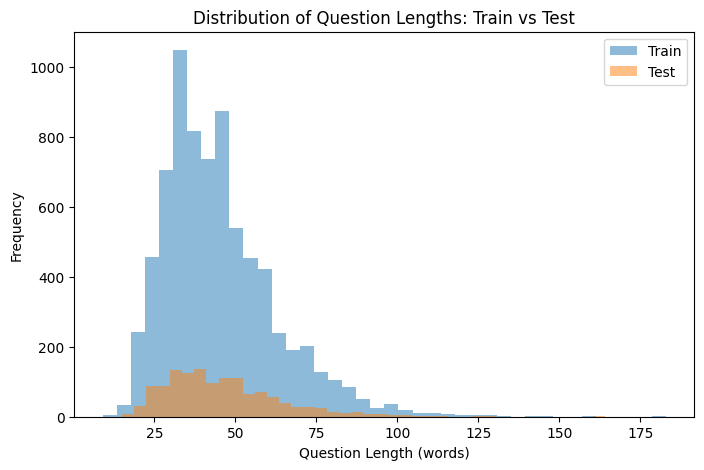

In [4]:
train_lens = ds["train"]["question"]
test_lens = ds["test"]["question"]

train_lengths = [len(q.split()) for q in train_lens]
test_lengths = [len(q.split()) for q in test_lens]

plt.figure(figsize=(8, 5))
plt.hist(train_lengths, bins=40, alpha=0.5, label="Train")
plt.hist(test_lengths, bins=40, alpha=0.5, label="Test")
plt.xlabel("Question Length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of Question Lengths: Train vs Test")
plt.legend()
plt.show()


# Construct accuracy curves

In [4]:
# reload scripts.load_results.py

import importlib
import scripts.load_results
importlib.reload(scripts.load_results)

<module 'scripts.load_results' from '/NL/strategic-compute/work/strategic-ttc/notebooks/../scripts/load_results.py'>

In [1]:
import sys
sys.path.append("..")

from scripts.load_results import load_results
from strategic_ttc.verifiers.boxed_number import parse_pred_from_explanation
from scripts.accuracy_analysis import compute_curves_for_model, plot_model_curves

/NL/strategic-compute/work/svenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing file: Qwen2-0.5B--temp-0.7--samples-128--max-512.jsonl
Processing file: R1-D-Qwen-1.5B--temp-0.6--samples-128--max-512.jsonl
Processing file: R1-D-Qwen-7B--temp-0.6--samples-128--max-512.jsonl
Processing file: gemma-3-4b--temp-0.7--samples-128--max-512.jsonl
Processing file: Llama-3.1-8B--temp-0.6--samples-128--max-512.jsonl
Processing file: Qwen2-7B--temp-0.7--samples-128--max-512.jsonl
Processing file: Llama-3-8B--temp-0.7--samples-128--max-512.jsonl
Processing file: Llama-3.2-1B--temp-0.6--samples-128--max-512.jsonl
Processing file: gemma-3-1b--temp-0.7--samples-128--max-512.jsonl
Processing file: Llama-3.2-3B--temp-0.7--samples-128--max-512.jsonl
Processing file: llama-3.2-3b--temp-0.6--samples-128--max-512.jsonl
Processing file: Qwen2-1.5B--temp-0.7--samples-128--max-512.jsonl
Processing file: Llama-3.1-8B--temp-0.7--samples-128--max-512.jsonl
Processing file: Llama-3.2-1B--temp-0.7--samples-128--max-512.jsonl
Bad JSON at line 309: Expecting value: line 1 column 1 (char

100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


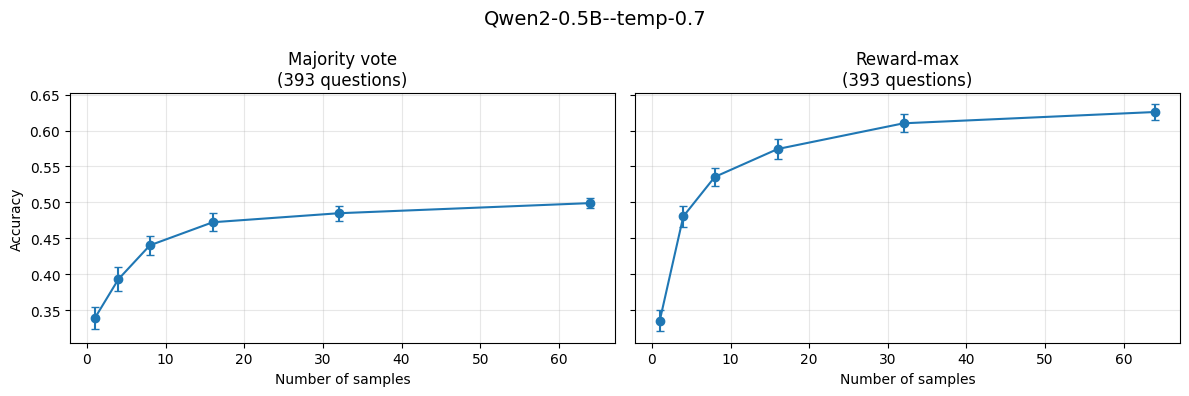

Processing model: R1-D-Qwen-1.5B--temp-0.6


100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


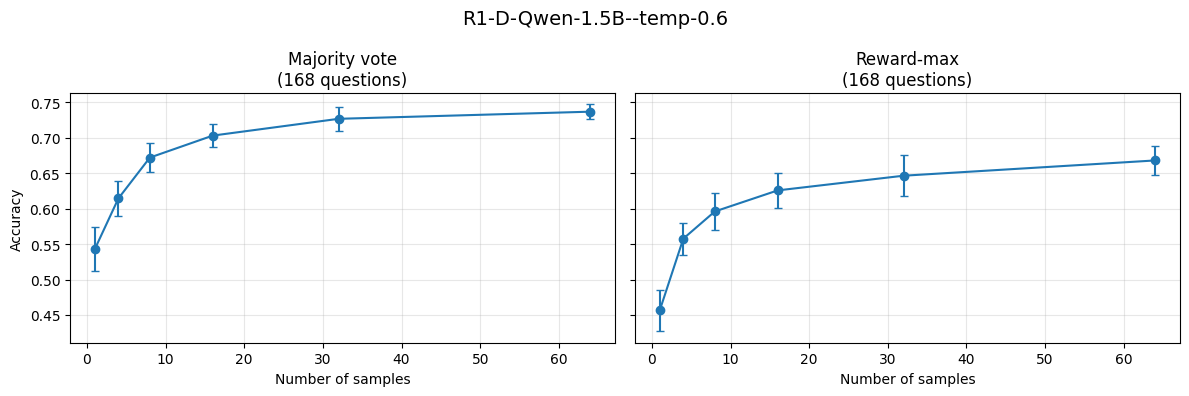

Processing model: R1-D-Qwen-7B--temp-0.6


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


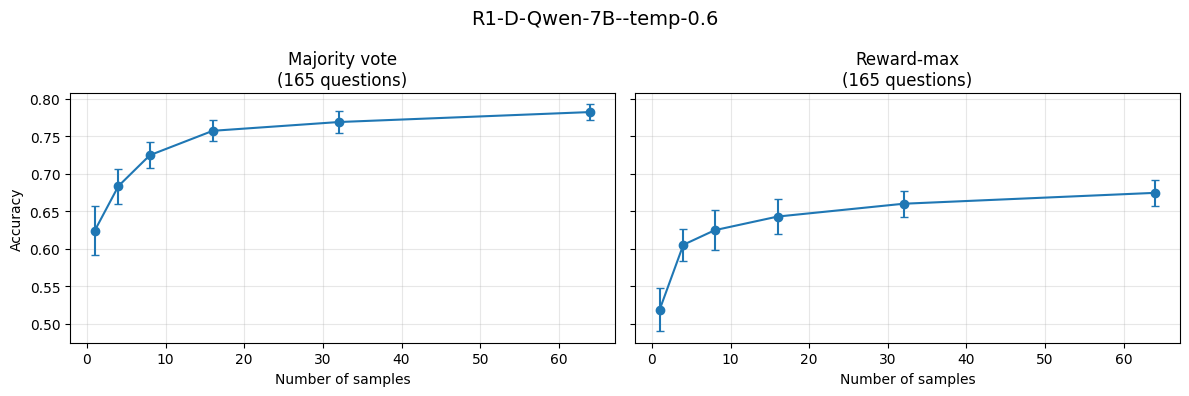

Processing model: gemma-3-4b--temp-0.7


100%|██████████| 6/6 [00:02<00:00,  2.29it/s]


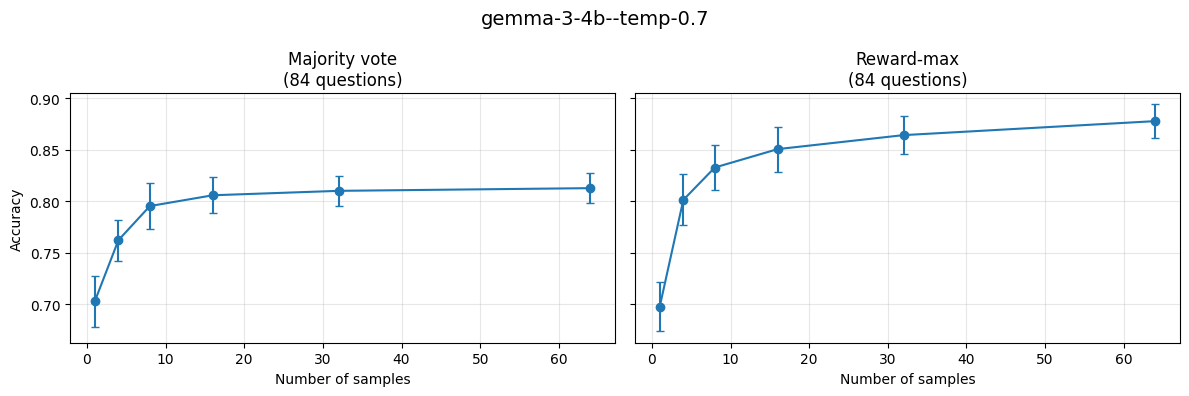

Processing model: Llama-3.1-8B--temp-0.6


100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


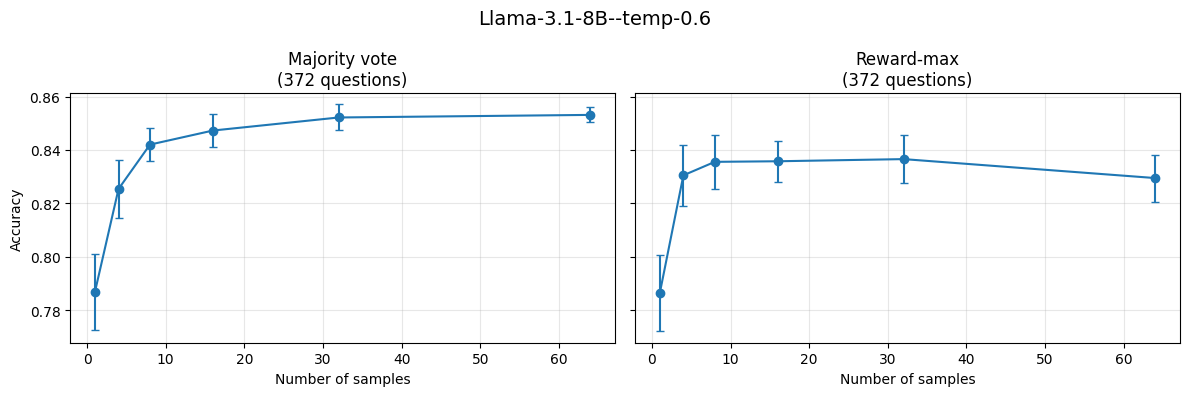

Processing model: Qwen2-7B--temp-0.7


100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


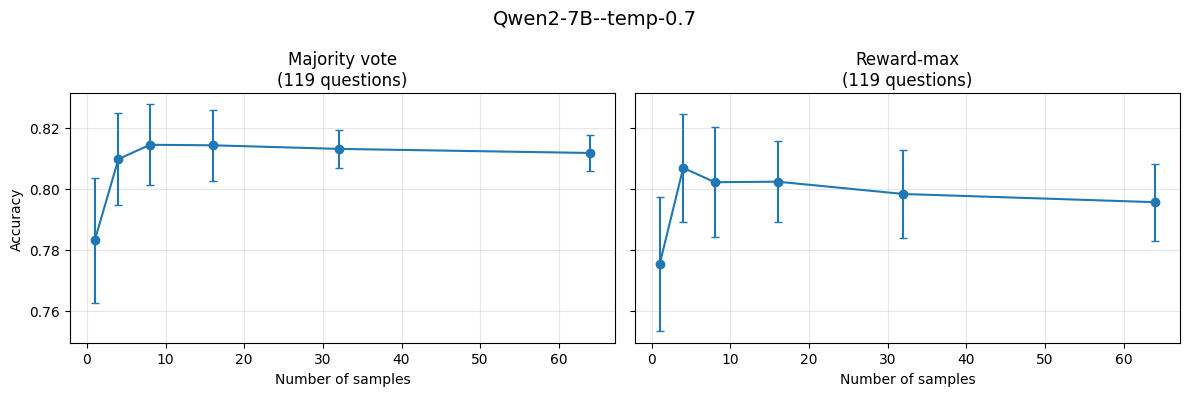

Processing model: Llama-3-8B--temp-0.7


100%|██████████| 6/6 [00:21<00:00,  3.53s/it]


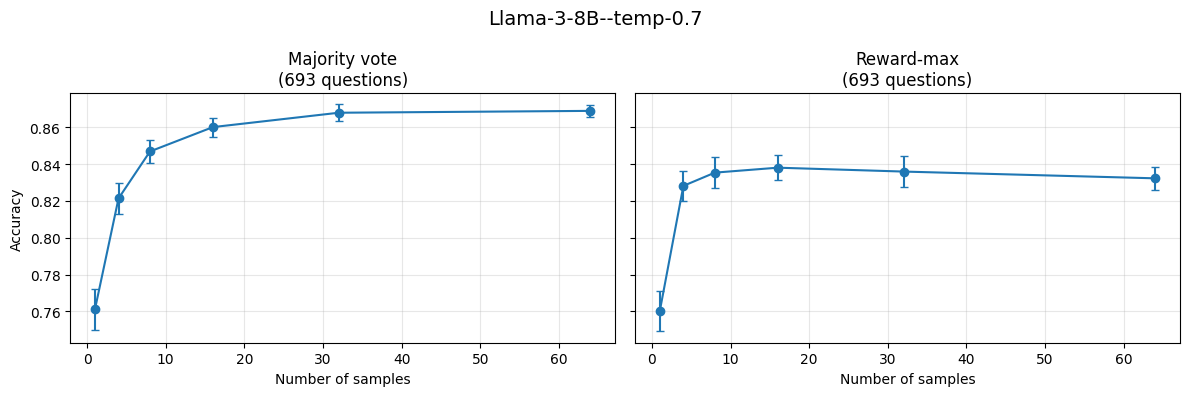

Processing model: Llama-3.2-1B--temp-0.6


100%|██████████| 6/6 [00:03<00:00,  1.75it/s]


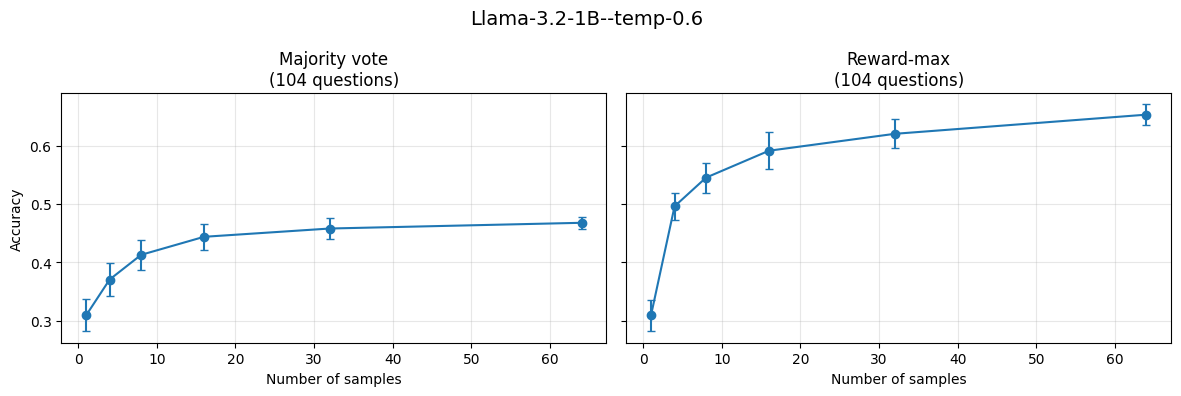

Processing model: gemma-3-1b--temp-0.7


100%|██████████| 6/6 [00:03<00:00,  1.99it/s]


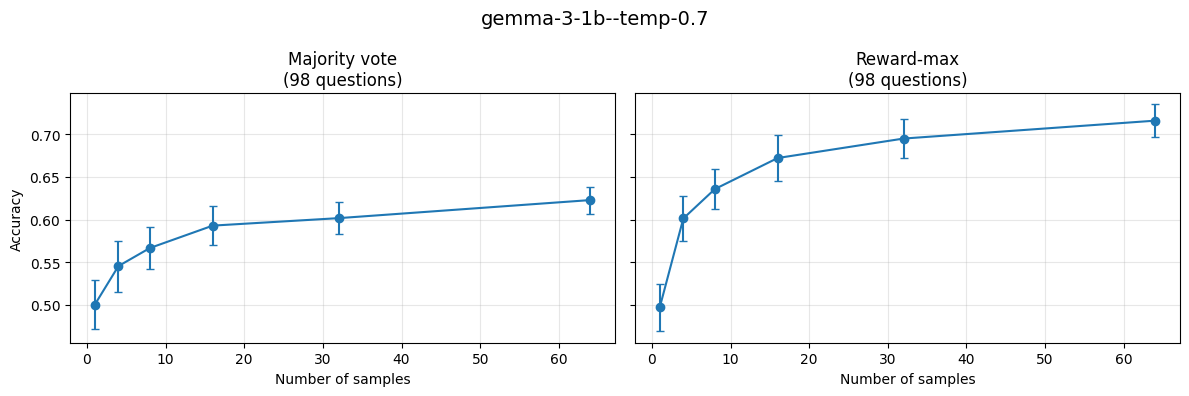

Processing model: Llama-3.2-3B--temp-0.7


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


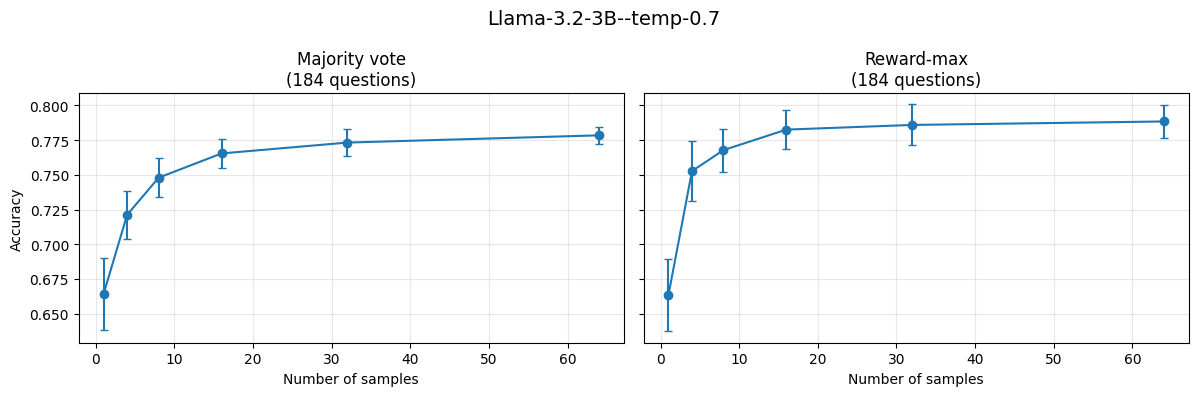

Processing model: llama-3.2-3b--temp-0.6


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


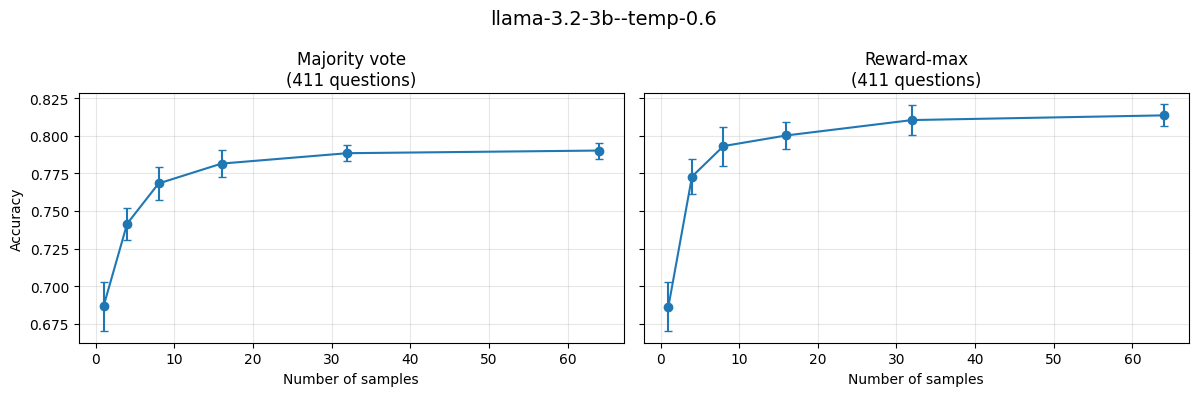

Processing model: Qwen2-1.5B--temp-0.7


100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


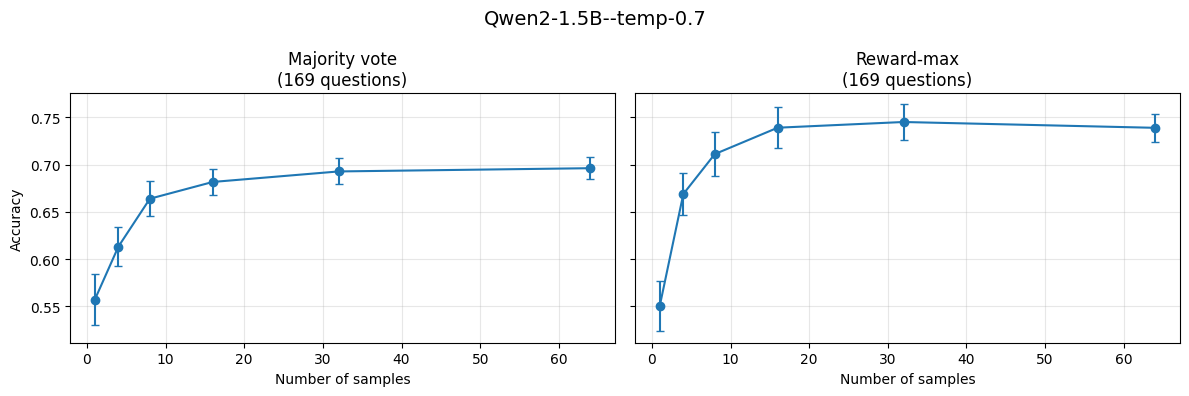

Processing model: Llama-3.1-8B--temp-0.7


100%|██████████| 6/6 [00:04<00:00,  1.27it/s]


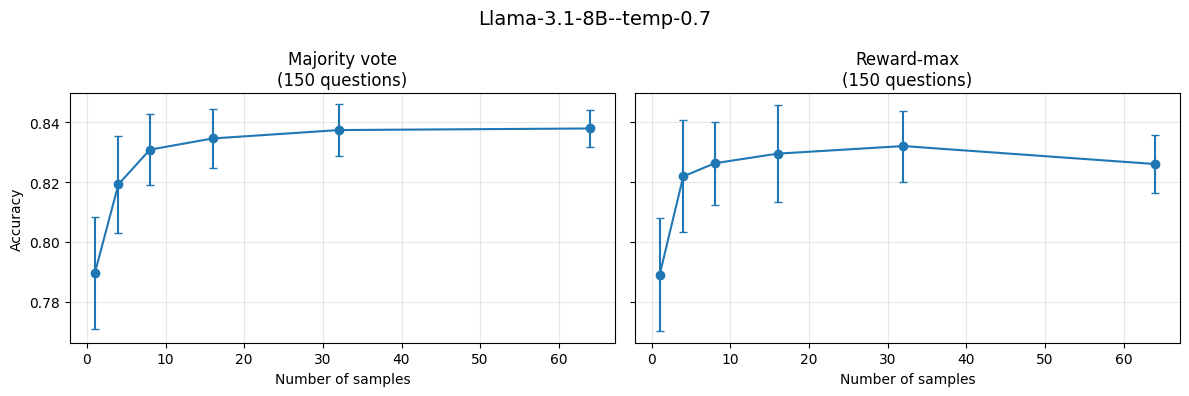

Processing model: Llama-3.2-1B--temp-0.7


100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


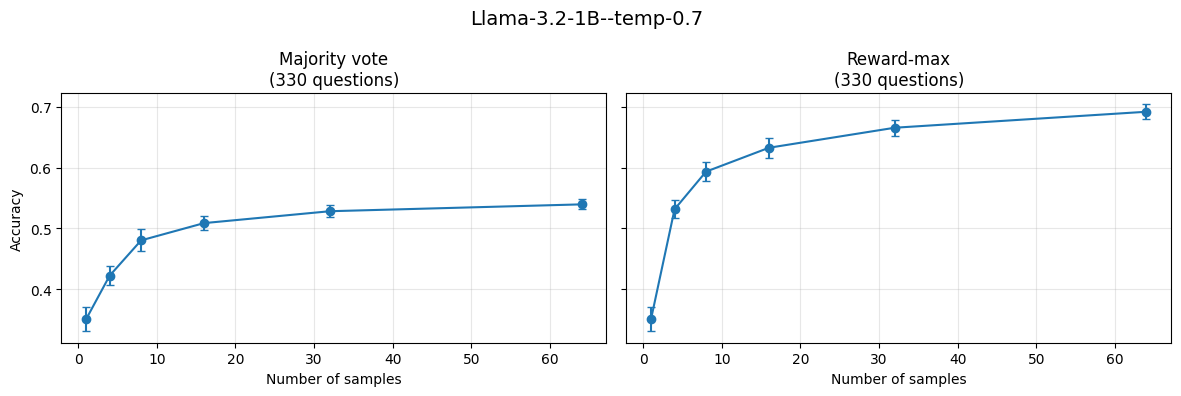

Processing model: Llama-3-8B--temp-0.6


100%|██████████| 6/6 [00:03<00:00,  1.95it/s]


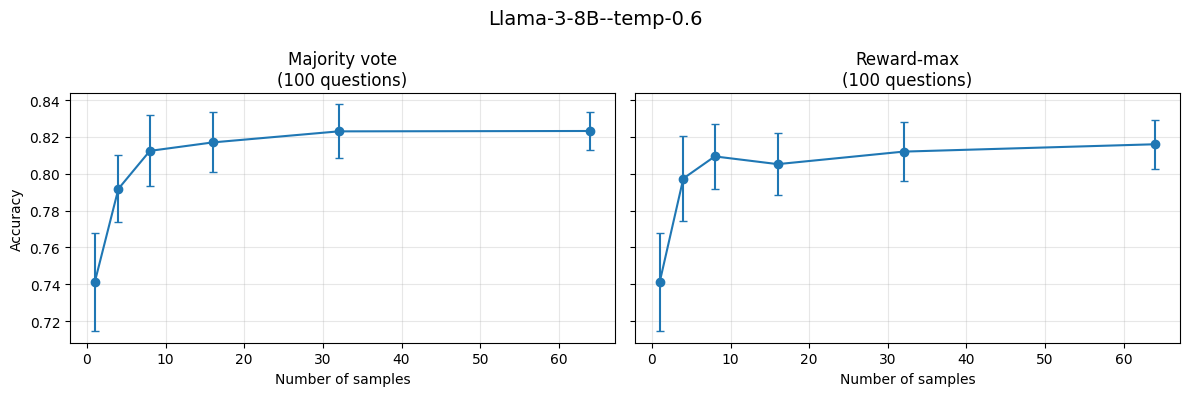

Processing model: llama-3.2-3b--temp-0.7


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


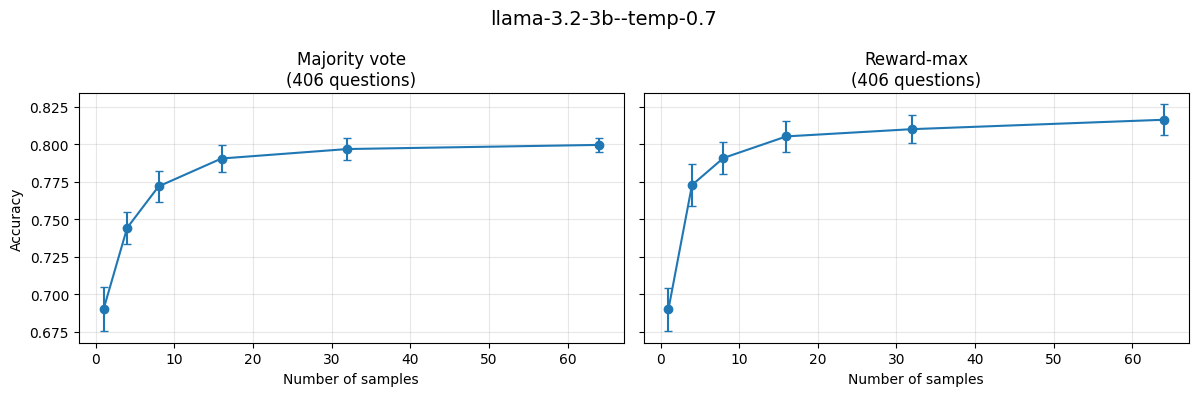

Processing model: R1-D-Llama-8B--temp-0.6


100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


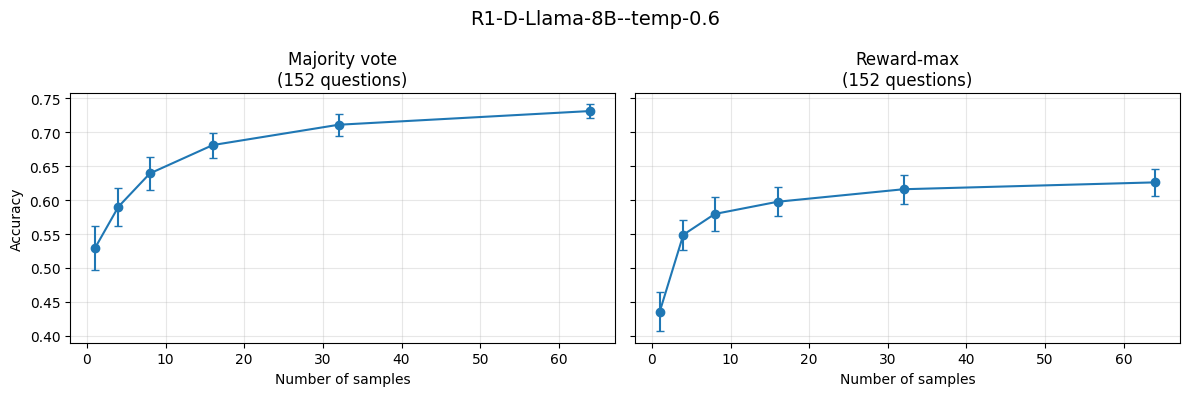

Processing model: toy


0it [00:00, ?it/s]


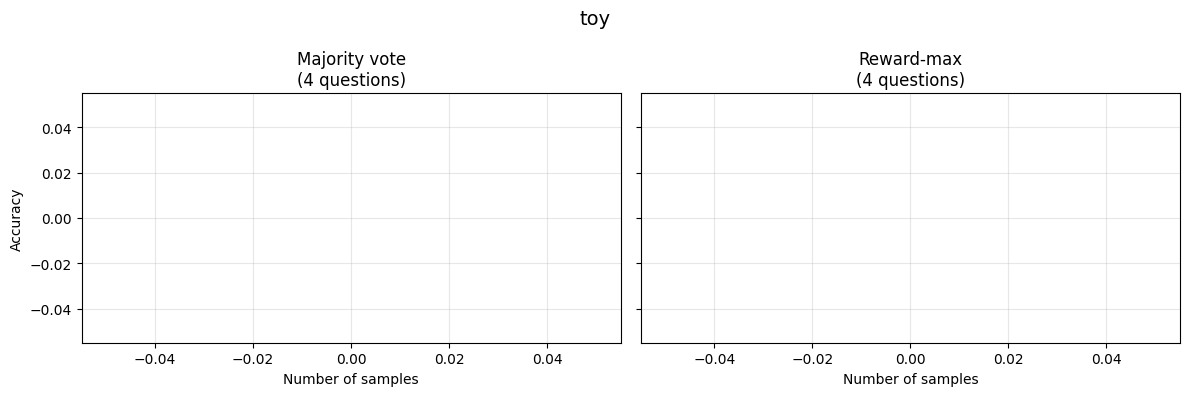

Processing model: Qwen2.5-3B--temp-0.7


100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


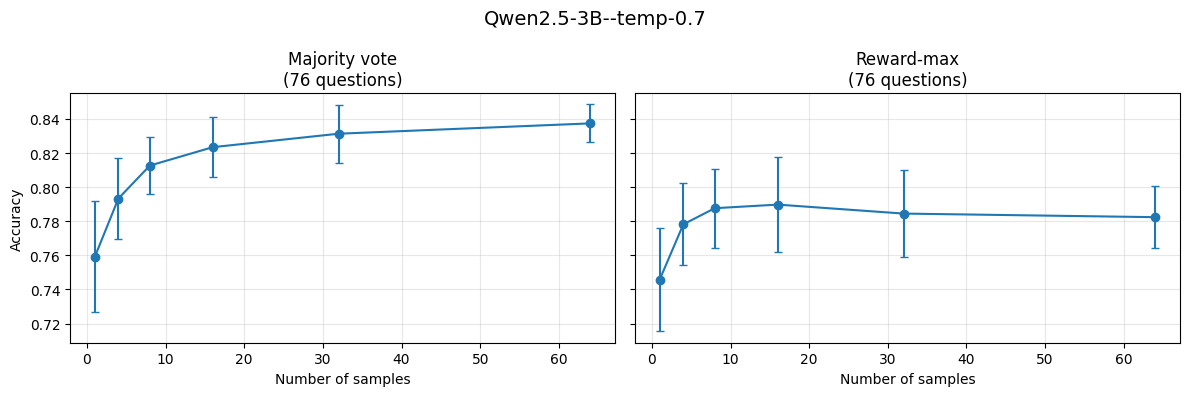

Processing model: Qwen2.5-7B--temp-0.7


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


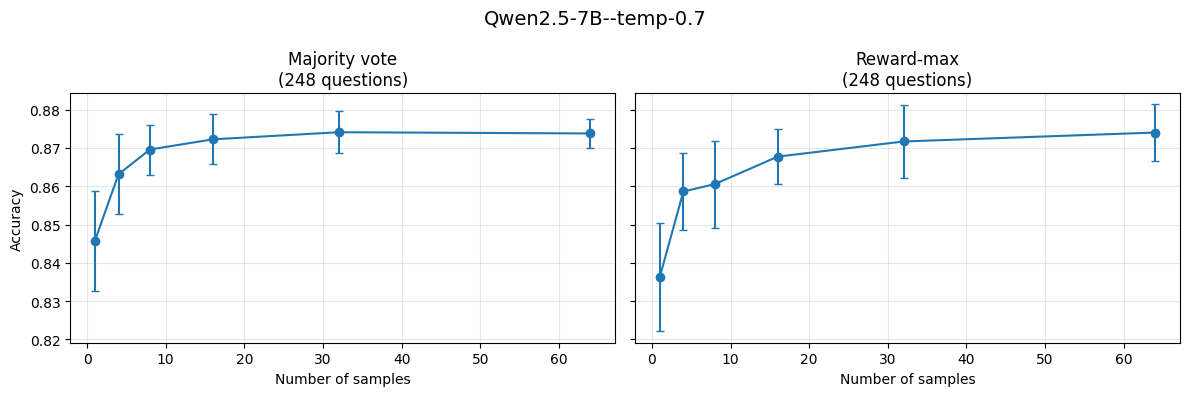

In [2]:
results = load_results("../runs/GSM8K")
maj_mean, maj_std, rew_mean, rew_std = {}, {}, {}, {}
token_mean, token_std = {}, {}
thetas = {}
for model_name, data in results.items():
    print(f"Processing model: {model_name}")
    thetas[model_name], maj_mean[model_name], maj_std[model_name], rew_mean[model_name], rew_std[model_name], token_mean[model_name], token_std[model_name] = compute_curves_for_model(
        data,
        parse_pred_fn=parse_pred_from_explanation,
        sample_size=50,
    )
    plot_model_curves(model_name, thetas[model_name], maj_mean[model_name], maj_std[model_name], rew_mean[model_name], rew_std[model_name], len(data['correct']))

In [3]:
token_mean

{'Qwen2-0.5B--temp-0.7': array([  192.56122137,   772.85292621,  1549.49582697,  3096.59323155,
         6191.63826972, 12380.55017812]),
 'R1-D-Qwen-1.5B--temp-0.6': array([  429.36369048,  1718.69940476,  3438.24464286,  6872.72154762,
        13754.67595238, 27502.31619048]),
 'R1-D-Qwen-7B--temp-0.6': array([  422.22254545,  1686.08884848,  3374.28618182,  6750.82545455,
        13497.15151515, 26989.00727273]),
 'gemma-3-4b--temp-0.7': array([  369.33690476,  1479.26642857,  2954.49666667,  5912.4952381 ,
        11818.63809524, 23637.57904762]),
 'Llama-3.1-8B--temp-0.6': array([  173.18290323,   693.50365591,  1386.17865591,  2770.33096774,
         5541.02311828, 11086.70387097]),
 'Qwen2-7B--temp-0.7': array([  214.79663866,   863.49327731,  1726.45327731,  3449.22336134,
         6904.29630252, 13798.44302521]),
 'Llama-3-8B--temp-0.7': array([  84.22721501,  337.22516595,  673.75186147, 1348.64135642,
        2696.61344877, 5394.20750361]),
 'Llama-3.2-1B--temp-0.6': array([

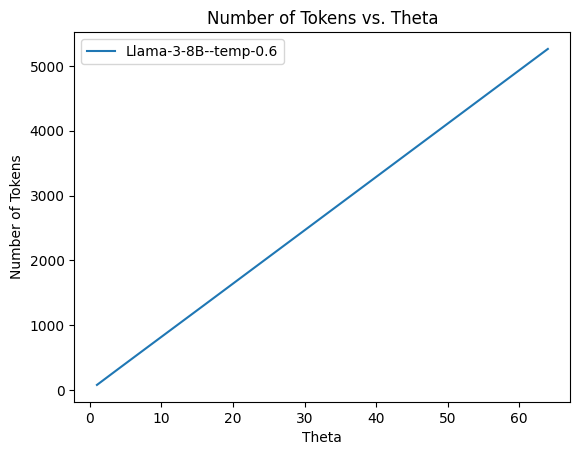

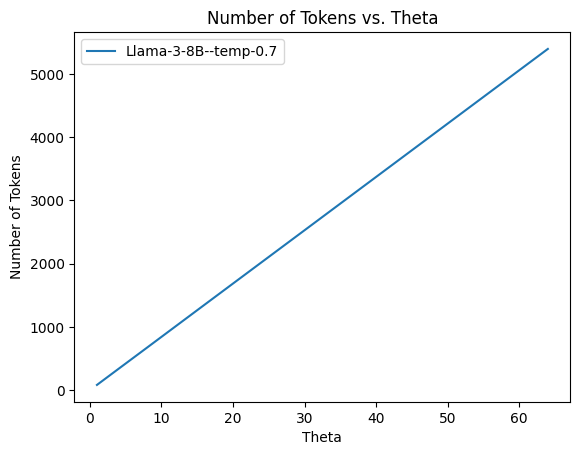

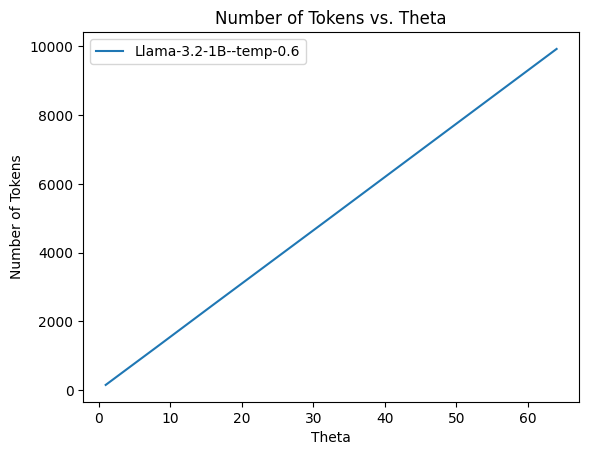

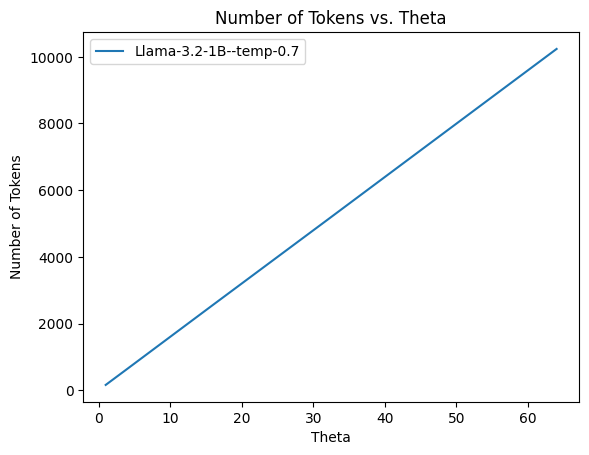

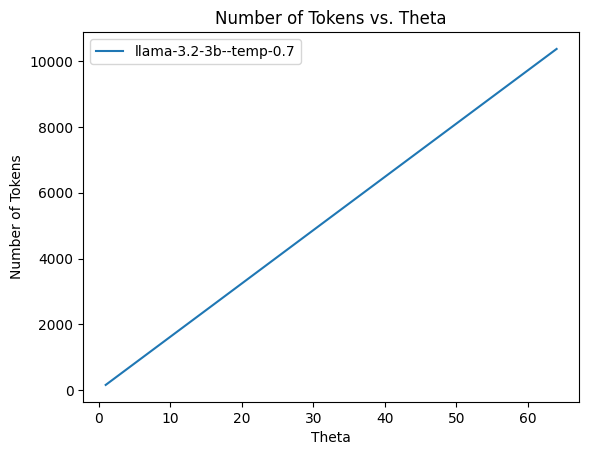

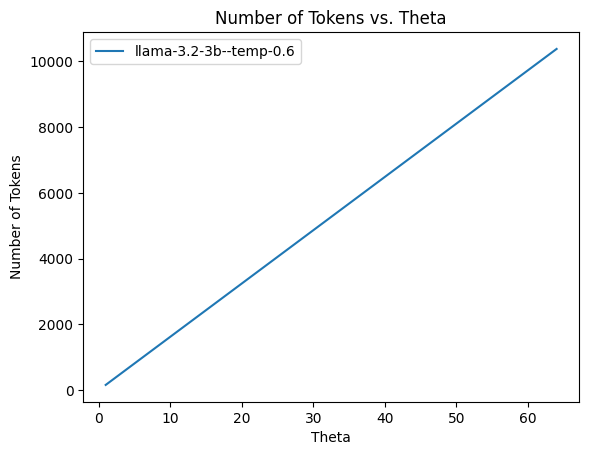

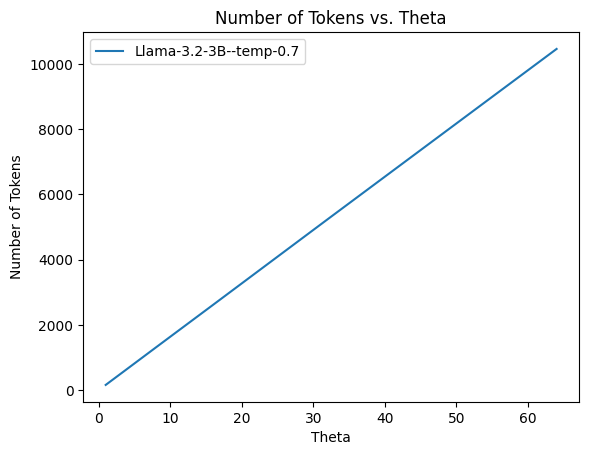

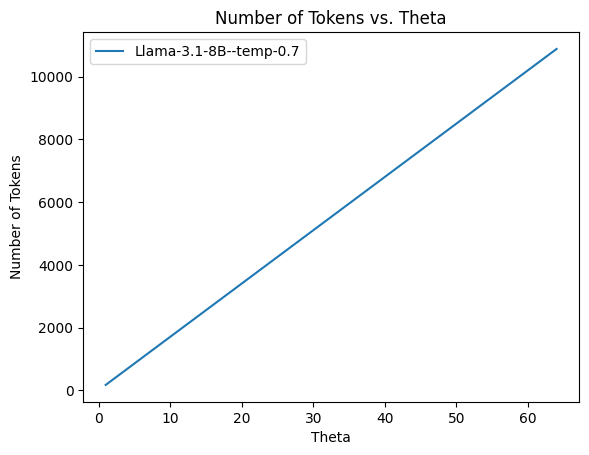

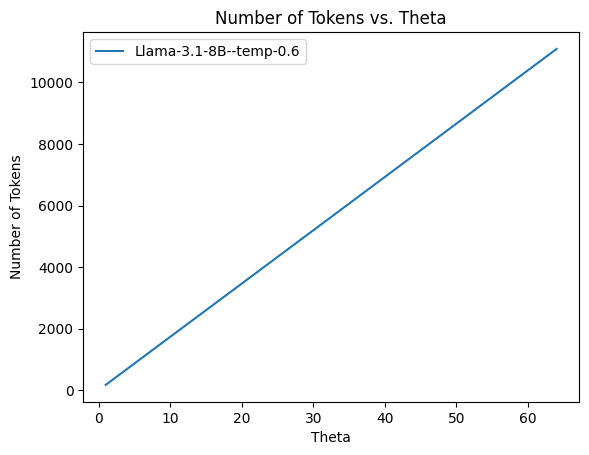

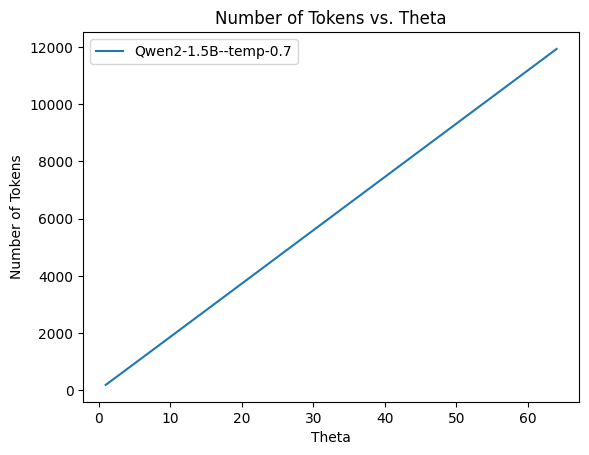

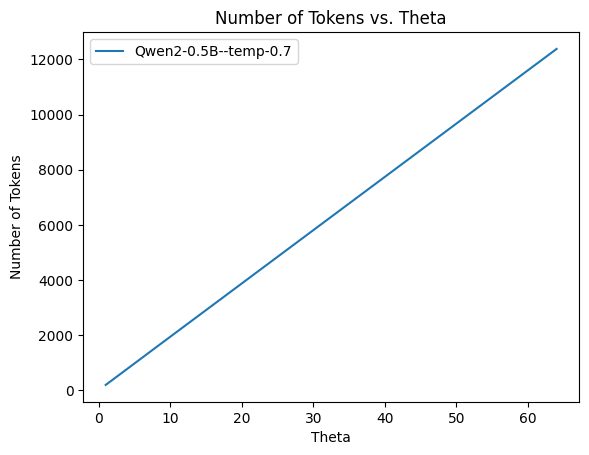

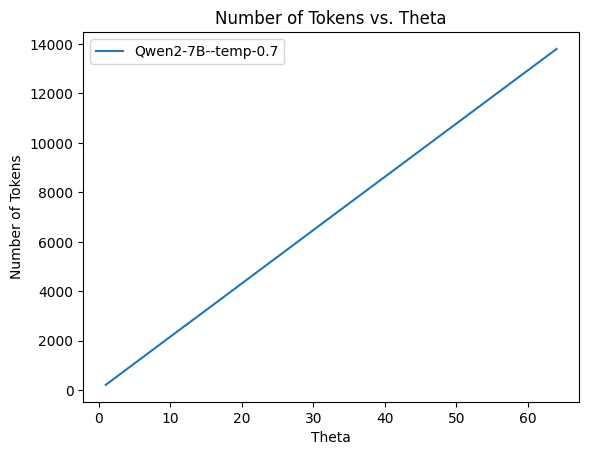

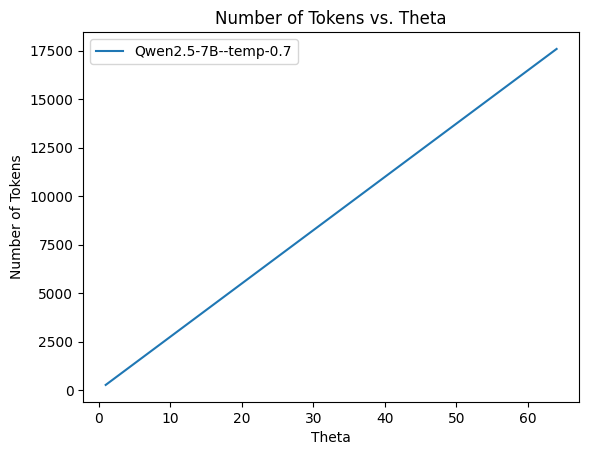

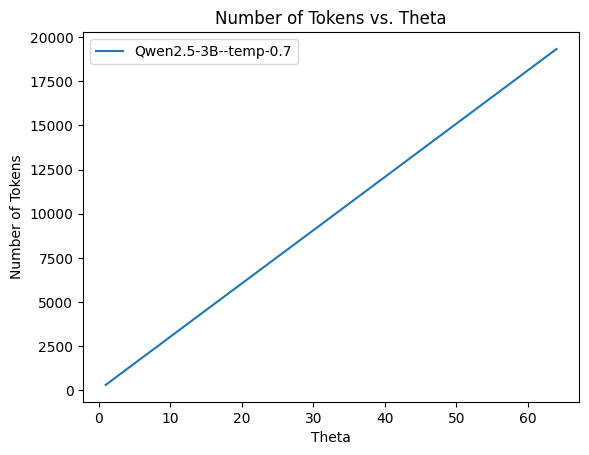

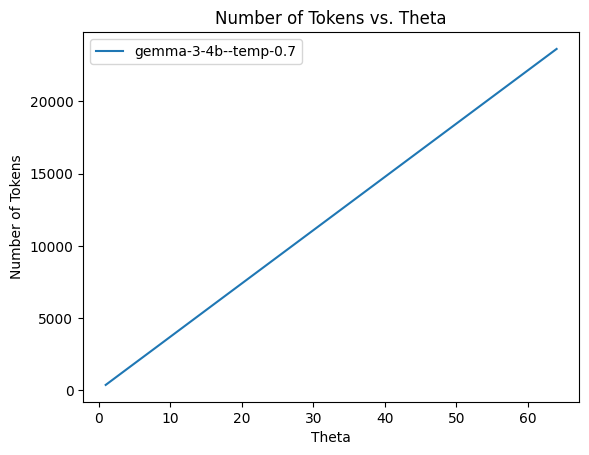

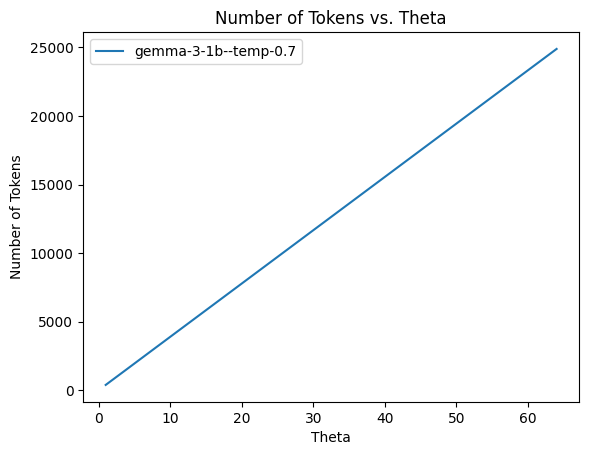

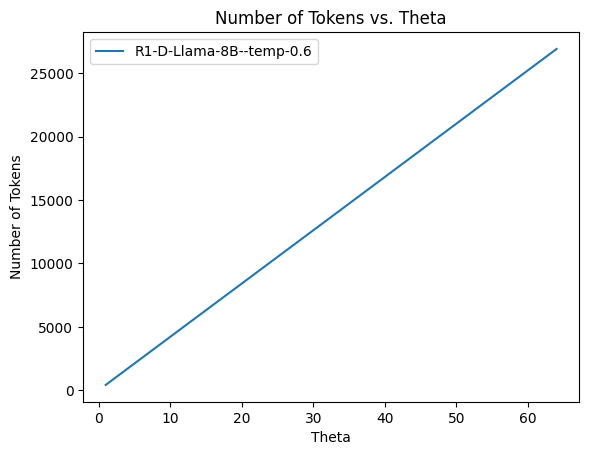

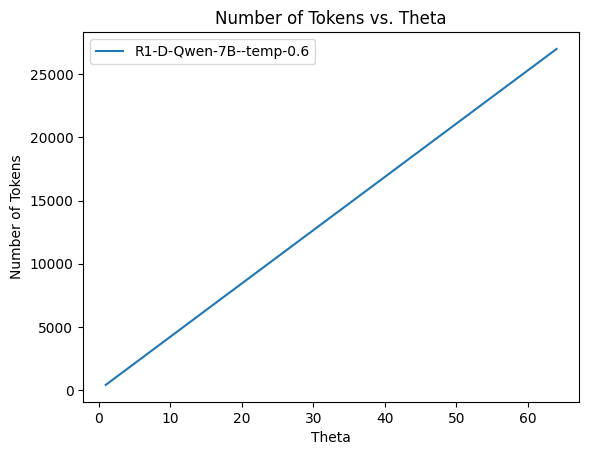

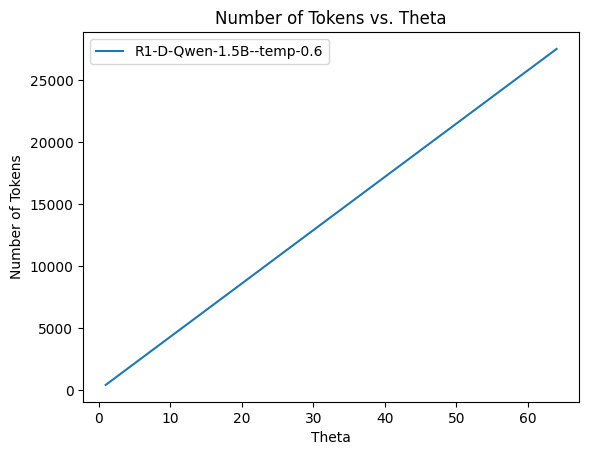

In [4]:
import matplotlib.pyplot as plt
import numpy as np
list_ = token_mean.items()
list_ = [(model, tokens) for model, tokens in list_ if not np.isnan(tokens).all()]
list_ = sorted(list_, key=lambda x: x[1][-1])

for model, tokens in list_:
    plt.plot(thetas[model], tokens, label=model)
    plt.xlabel("Theta")
    plt.ylabel("Number of Tokens")
    plt.title("Number of Tokens vs. Theta")
    plt.legend()
    plt.show()

# Equilibrium

In [5]:
accuracyA = maj_mean["Llama-3.2-1B--temp-0.6"]
thetasA = thetas["Llama-3.2-1B--temp-0.6"]
accuracyB = maj_mean["Qwen2-0.5B--temp-0.7"]
thetasB = thetas["Qwen2-0.5B--temp-0.7"]